In [168]:
import pandas as pd
import plotly
from pathlib import Path
import plotly.express as px
import plotly.graph_objects as go
from tqdm.auto import tqdm

from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier

In [2]:
df = pd.read_csv(Path('../data/train.csv'))

In [3]:
df.id.unique()

array([  1,   2,   3,   4,   5,   6,   7,  10,  12,  13,  14,  15,  16,
        17,  19,  20,  21,  22,  23,  24,  25,  27,  29,  30,  31,  32,
        33,  34,  35,  36,  38,  39,  40,  41,  42,  43,  44,  45,  46,
        47,  48,  49,  51,  52,  53,  54,  55,  57,  58,  59,  60,  61,
        62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,
        75,  76,  77,  78,  79,  80,  82,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  96,  97,  99, 100, 101, 102, 103, 104, 107,
       108, 109, 110, 111, 112, 113, 115, 116, 117, 118, 119, 120, 121,
       122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134,
       136, 137, 138, 139, 140, 143, 144, 145, 146, 147, 148, 149, 150,
       151, 152, 153, 155, 156, 158, 159, 160, 161, 162, 163, 164, 167,
       169, 170, 172, 173, 174, 177, 178, 179, 180, 182, 185, 186, 187,
       188, 189, 190, 191, 193, 194, 195, 196, 197, 199, 201, 202, 203,
       204, 205, 206, 207, 208, 209, 213, 214, 215, 216, 217, 21

In [4]:
df.head(5)

,id,time,x,y
0,1,0,800,0
1,1,780,780,0
2,1,1572,792,0
3,1,2392,820,0
4,1,3196,804,0


In [6]:
df = df.sort_values(['id', 'time'])

In [13]:
prev_id = 0
prev_y = 0
num_observ = 0
markers = []
for i,r in tqdm(df.iterrows(), total=df.shape[0]):
    if prev_id < r['id']:
        if r['y'] == 1:
            num_observ += 1
            markers.append(num_observ)
        else:
            markers.append(0)
    else:
        if r['y'] == 1:
            if prev_y == 1:
                markers.append(num_observ)
            else:
                num_observ += 1
                markers.append(num_observ)       
        else:
            markers.append(0)
    prev_y = r['y']
    prev_id = r['id']
df['spike'] = markers

  0%|          | 0/60487 [00:00<?, ?it/s]

In [18]:
df.drop(columns=['spikes'], inplace=True)

In [26]:
spikes = df[df.spike > 0].groupby('spike').agg({'x': ['min', 'max', 'mean', 'std'], 'id': 'count'})

In [32]:
spikes.columns = ['x_min', 'x_max', 'x_mean', 'x_std', 'id']

<AxesSubplot:>

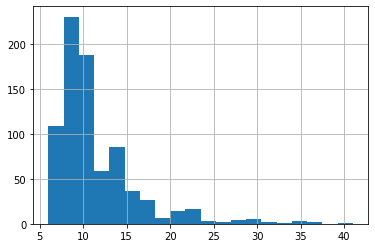

In [34]:
spikes['id'].hist(bins=20)

Мы видим что ширина спайка это 17-18 точек

<AxesSubplot:>

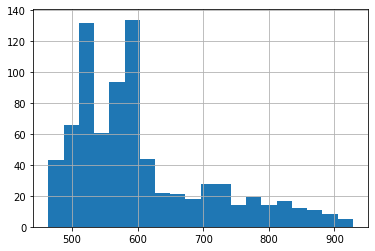

In [39]:
spikes['x_min'].hist(bins=20)

In [87]:
spikes['x_min'].min()

464

<AxesSubplot:>

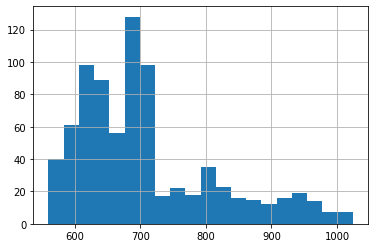

In [40]:
spikes['x_max'].hist(bins=20)

In [88]:
spikes['x_max'].max()

1024

<AxesSubplot:>

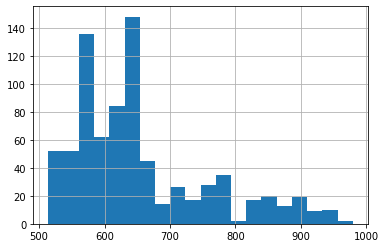

In [41]:
spikes['x_mean'].hist(bins=20)

<AxesSubplot:>

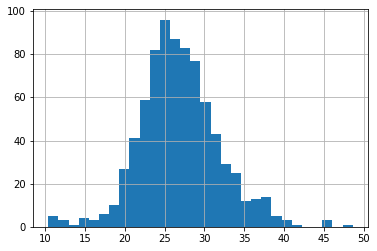

In [43]:
spikes['x_std'].hist(bins=30)

In [202]:
for q in [108]:
    t = df.loc[df['id'] == q].sort_values('time').reset_index(drop=True)
    fig = go.Figure()
#     fig = px.line(t, x='time', y='x', name='R-R')
    
    fig.add_trace(go.Scatter(x=t['time'], y=t['x'],
                        mode='lines',
                        name='R-R'))
    qt = t.loc[t.y==1].reset_index(drop=True)
    fig.update_traces(line=dict(color="blue", width=0.3))
    fig.add_trace(go.Scatter(x=qt['time'], y=qt['x'],
                        mode='markers', name='Spikes', opacity = 0.8))
    fig.show()

In [45]:
import numpy as np

In [107]:
samples = df['id'].unique()
WINDOW_SIZE = 17
HALF_WINDOW = int((WINDOW_SIZE-1)/2)
QART_WINDOW = int((WINDOW_SIZE-1)/4)
LOW_BOUND = 450
UPPER_BOUND = 1050

In [135]:
def pop_arr(arr, num):
    s = len(arr)
    return np.resize(np.repeat(np.resize(arr[:s], (1,s)), num, axis=0), (num*s,))

In [234]:
def timedomain(rr, mask):
    results = {}
    
    rr = rr[mask==1]
    
    if len(rr) > 1:
        hr = 60000/rr
    
        results['mean_RR'] = np.mean(rr)
        results['std_rr_sdnn'] = np.std(rr)
        results['mean_hr_kubious'] = 60000/np.mean(rr)
        results['mean_hr'] = np.mean(hr)
        results['std_hr'] = np.std(hr)
        results['min_hr'] = np.min(hr)
        results['max_hr'] = np.max(hr)
        results['rmssd'] = np.sqrt(np.mean(np.square(np.diff(rr))))
        results['nn_xx'] = np.sum(np.abs(np.diff(rr)) > 50)*1
        results['pnn_xx'] = 100 * np.sum((np.abs(np.diff(rr)) > 50)*1) / len(rr)
    else:
        results['mean_RR'] = 0
        results['std_rr_sdnn'] = 0
        results['mean_hr_kubious'] = 0
        results['mean_hr'] = 0
        results['std_hr'] = 0
        results['min_hr'] = 0
        results['max_hr'] = 0
        results['rmssd'] = 0
        results['nn_xx'] = 0
        results['pnn_xx'] = 0

    return results

In [235]:
new_df = []
for sample in tqdm(samples):
    # get array
    loc_df = df[df.id==sample].sort_values('time').reset_index(drop=True)
    arr = loc_df['x'].values
    
    target = loc_df['y'].values
    
    time = loc_df['time'].values
    
    mask = ((arr>LOW_BOUND) & (arr < UPPER_BOUND)).astype(int)
    # ext array with 8 points to each direction
    
    arr = np.concatenate((
        pop_arr(arr[:2], QART_WINDOW),
        arr,
        pop_arr(arr[-2:], QART_WINDOW),
    ))
    
    mask = np.concatenate((
        pop_arr([0], HALF_WINDOW),
        mask,
        pop_arr([0], HALF_WINDOW)
    ))
    for i in range(HALF_WINDOW+1, len(arr)-HALF_WINDOW+1):
        local_window = arr[i-HALF_WINDOW-1:i+HALF_WINDOW+2]
        local_mask = mask[i-HALF_WINDOW-1:i+HALF_WINDOW+2]
        new_df.append({'id': sample, 
                       'ts': time[i-HALF_WINDOW-1],
                       **{f"x_{x}":y for x,y in zip(range(-8,9), local_window)},
                      'target': target[i-HALF_WINDOW-1],
                       **{f"mask_{x}":y for x,y in zip(range(-8,9), local_mask)},
                       **timedomain(local_window, local_mask),
                       **{f"delta_{x}":y for x,y in zip(range(WINDOW_SIZE-1), np.diff(local_window))},
                      })


  0%|          | 0/229 [00:00<?, ?it/s]

In [236]:
new_df=pd.DataFrame(new_df)
new_df.head()

,id,ts,x_-8,x_-7,x_-6,x_-5,x_-4,x_-3,x_-2,x_-1,...,delta_6,delta_7,delta_8,delta_9,delta_10,delta_11,delta_12,delta_13,delta_14,delta_15
0,1,0,800,780,800,780,800,780,800,780,...,-20,20,-20,12,28,-16,24,88,44,-4
1,1,780,780,800,780,800,780,800,780,800,...,20,-20,12,28,-16,24,88,44,-4,-28
2,1,1572,800,780,800,780,800,780,800,780,...,-20,12,28,-16,24,88,44,-4,-28,-92
3,1,2392,780,800,780,800,780,800,780,792,...,12,28,-16,24,88,44,-4,-28,-92,-44
4,1,3196,800,780,800,780,800,780,792,820,...,28,-16,24,88,44,-4,-28,-92,-44,-16


In [237]:
new_df.shape

(60487, 63)

In [238]:
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score

def threshold_search(y_true, y_proba):
    precision , recall, thresholds = precision_recall_curve(y_true, y_proba)
    thresholds = np.append(thresholds, 1.001) 
    F = 2 / (1 / (precision + 1e-18) + 1 / (recall + 1e-18))
    F[F>1.0] = 0
    best_score = np.max(F)
    best_th = thresholds[np.argmax(F)]
    return best_th , best_score

In [243]:
lgbm_params = {
    'num_leaves': 52, 
    'learning_rate': 0.028067101239171117, 
    'class_weight': None, 
    'min_split_gain': 0.2079596284724723, 
    'min_child_samples': 26, 
    'subsample': 0.9964018869175387, 
    'subsample_freq': 3, 
    'colsample_bytree': 0.7621469158134937, 
    'reg_alpha': 0.0007822636610799144, 
    'reg_lambda': 4.076057666254058,
    'boosting_type': 'gbdt',  
    'objective': 'binary',  
    'n_estimators': 3000, 
    'random_state': 13
}

In [244]:
drop_cols = ['id', 'ts', 'target']
traget_col = 'target'

In [247]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
ifold = 0
df_ids = df['id'].unique()
f1_folds = []
for train_id, val_id in kf.split(df_ids):
    model = LGBMClassifier(**lgbm_params)
    train_samples = df_ids[train_id]
    val_samples = df_ids[val_id]
    
    train_df = new_df[new_df.id.isin(train_samples)]
    val_df = new_df[new_df.id.isin(val_samples)]
    
    model.fit(train_df.drop(columns=drop_cols), train_df[traget_col])
    
    train_y_true = train_df[traget_col].values
    train_y_proba = model.predict_proba(train_df.drop(columns=drop_cols))[:,1]
    best_th , best_score = threshold_search(train_y_true, train_y_proba)
    

    val_y_proba = model.predict_proba(val_df.drop(columns=drop_cols))[:,1]
    val_y_true = val_df[traget_col].values.astype(int)
    score = f1_score(val_y_true, (val_y_proba > best_th).astype(int))
    
    print(f"Fold: {ifold}, treshhold: {best_th}, val_f1: {score}, train_f1 {best_score}")
    f1_folds.append(score)
    ifold += 1

Fold: 0, treshhold: 0.48683899048033963, val_f1: 0.8225806451612904, train_f1 0.9897293546148507
Fold: 1, treshhold: 0.5147259296033303, val_f1: 0.7400626355095159, train_f1 0.9914048189375793
Fold: 2, treshhold: 0.4699847233148851, val_f1: 0.8674842955429255, train_f1 0.9878699660359049
Fold: 3, treshhold: 0.49360861821308155, val_f1: 0.840485350695472, train_f1 0.9889649392373235
Fold: 4, treshhold: 0.4727801540771783, val_f1: 0.8758700696055683, train_f1 0.9891585647338603


In [248]:
np.mean(f1_folds)

0.8292965993029544

In [249]:
f1_folds

[0.8225806451612904,
 0.7400626355095159,
 0.8674842955429255,
 0.840485350695472,
 0.8758700696055683]